In [3]:
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set(style="white", color_codes=True)

import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import roc_auc_score

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

In [6]:
# Input data files are available in the "./input/" directory.

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

test.csv
train.csv



In [7]:
print('Load data...')
train = pd.read_csv("./input/train.csv")
train_id = train['ID'].values
target = train['TARGET'].values

test = pd.read_csv("./input/test.csv")
test_id = test['ID'].values

Load data...


In [8]:
# happy customers have TARGET == 0, unhappy custormers have TARGET == 1
# A little less then 4% are unhappy => unbalanced dataset
df = pd.DataFrame(train.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train.shape[0]
df

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


In [7]:
train.shape

(76020, 371)

In [8]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [9]:
test.shape

(75818, 370)

In [10]:
test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


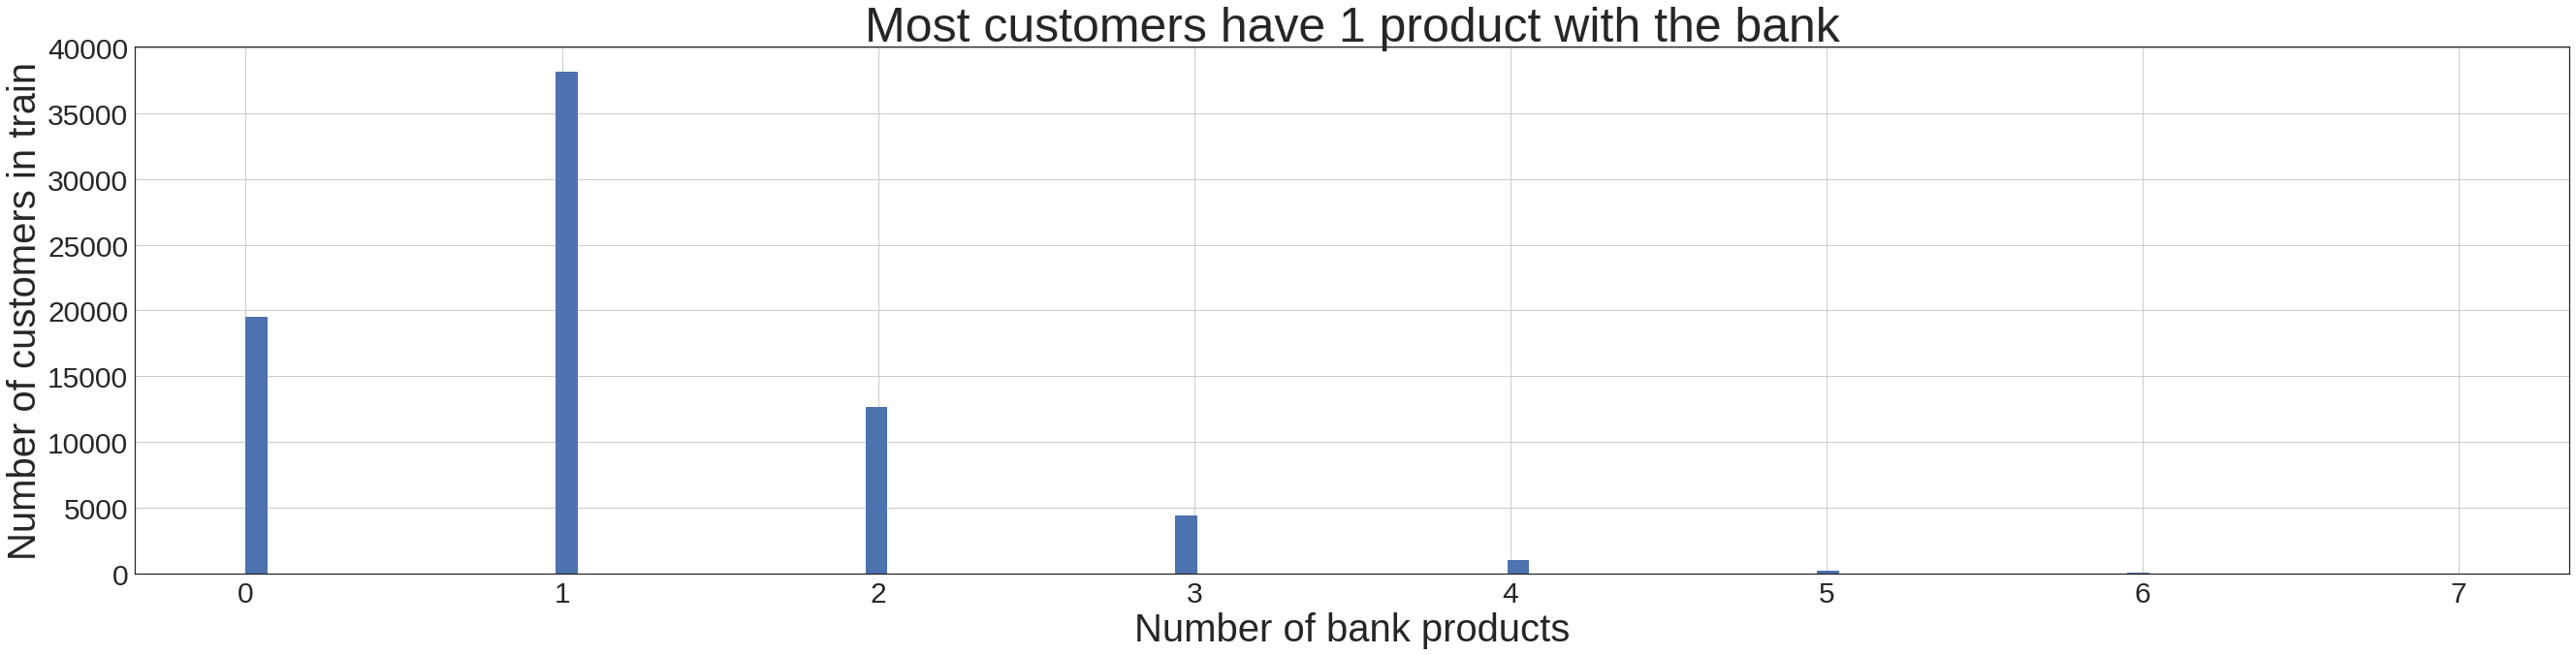

In [11]:
plt.figure(figsize=(45,10))
plt.tick_params(labelsize=30)
train.num_var4.hist(bins=100)

plt.xlabel('Number of bank products', fontsize = 40)
plt.ylabel('Number of customers in train', fontsize = 40)
plt.title('Most customers have 1 product with the bank', fontsize = 50)
plt.show()

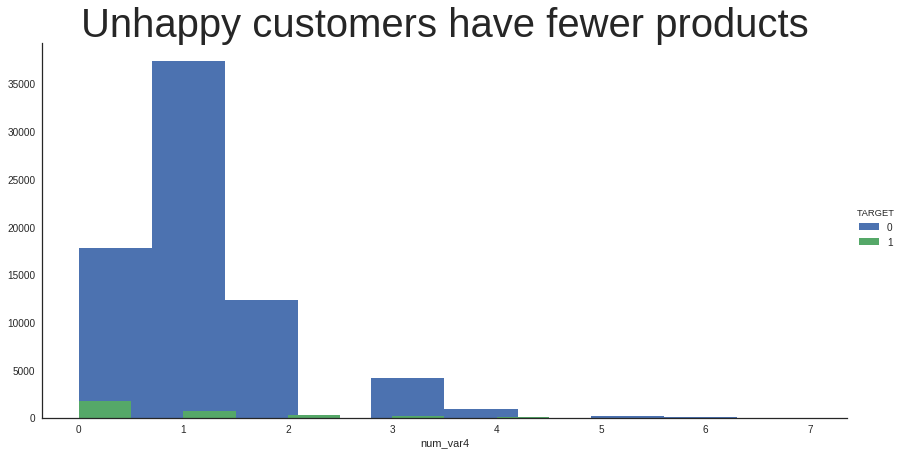

In [12]:
sns.FacetGrid(train, hue="TARGET", size=6, aspect=2) \
   .map(plt.hist, "num_var4") \
   .add_legend()
plt.title('Unhappy customers have fewer products', fontsize = 40)
plt.show()

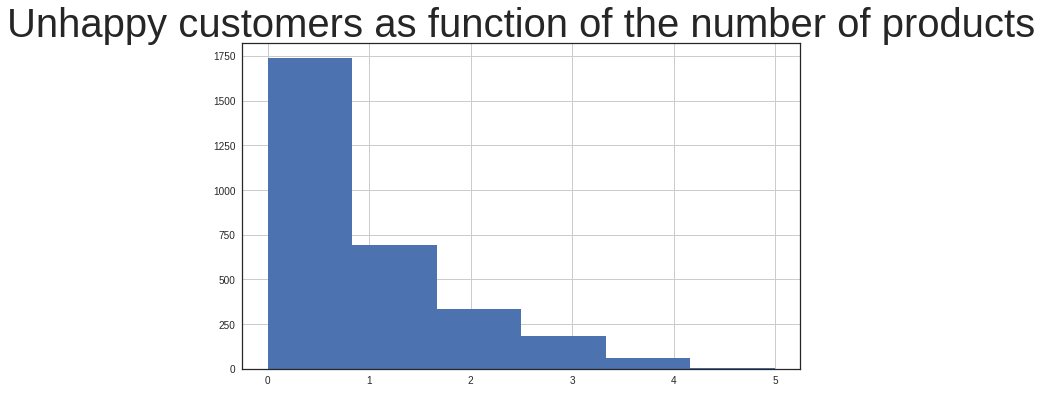

In [13]:
%matplotlib inline
plt.figure(figsize=(10, 6))

train[train.TARGET==1].num_var4.hist(bins=6)
plt.title('Unhappy customers as function of the number of products', fontsize = 40);

In [9]:
train = train.drop(['ID','TARGET'],axis=1)
test = test.drop(['ID'],axis=1)

In [10]:
# removing placeholders
train = train.replace(-999999, 2)
test = test.replace(-999999, 2)

In [11]:
# adding zero counts
train["zeroes"] = (train == 0).astype(int).sum(axis=1)
test["zeroes"] = (test == 0).astype(int).sum(axis=1)

# remove constant columns (std = 0)
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

print(train.shape, test.shape)

(76020, 336) (75818, 336)


In [12]:
Cols = train.columns.values.tolist()
clf = GradientBoostingClassifier(random_state = 8001)

selector = clf.fit(train, target)
importances = selector.feature_importances_
fs = SelectFromModel(selector, prefit=True)
train = fs.transform(train)
test = fs.transform(test)
print(train.shape, test.shape)

(76020, 50) (75818, 50)


In [13]:
selectedCols = train.shape[1]
sortedCols = [col for importance, col  in sorted(zip(importances, Cols))]
sortedCols = sortedCols[0:selectedCols]
train = pd.DataFrame(train)
test = pd.DataFrame(test)
train.columns = sortedCols
test.columns = sortedCols

print(sortedCols[0:5])

['delta_imp_amort_var18_1y3', 'delta_imp_amort_var34_1y3', 'delta_imp_aport_var13_1y3', 'delta_imp_aport_var17_1y3', 'delta_imp_aport_var33_1y3']


In [14]:
train = train.replace(np.inf, 999999)
train = train.replace(-np.inf, -999999)
train = train.replace(np.nan, -1)
test = test.replace(np.inf, 999999)
test = test.replace(-np.inf, -999999)
test = test.replace(np.nan, -1)

In [15]:
# Second round of gradient boosting
Cols = train.columns.values.tolist()
clf = GradientBoostingClassifier(random_state=1729)
selector = clf.fit(train, target)

importances = selector.feature_importances_
fs = SelectFromModel(selector, prefit=True)
train = fs.transform(train)
test = fs.transform(test)
print(train.shape, test.shape)

selectedCols = train.shape[1]
sortedCols = [col for importance, col  in sorted(zip(importances, Cols))]
sortedCols = sortedCols[0:selectedCols]

(76020, 15) (75818, 15)


In [1]:
import xgboost as xgb

/home/griffin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
from sklearn.cross_validation import KFold

In [17]:
# Create an empty array for prediction
predictedResult = np.zeros(train.shape[0])

# Split dataset into k = 10 consecutive folds
# Each fold is used once as a validation while the k - 1 remaining folds form the training set
kf = KFold(train.shape[0], n_folds=10)

testPred = []

for trainIndex, testIndex in kf:
    trainFold, testFold = train[trainIndex], train[testIndex]
    trainFoldTarget, testFoldTarget = target[trainIndex], target[testIndex]
    
    xgbc = xgb.XGBClassifier(n_estimators = 560, # number of boosted trees
                             learning_rate = 0.0202047, # step size shrinkage used in update to prevent overfitting
                             max_depth = 5, # maximum depth of a tree
                             subsample = 0.6815, # subsample ratio of the training set (Stochastic gradient boosting)
                             colsample_bytree = 0.701) # subsample features
    
    xgbc.fit(trainFold, trainFoldTarget)
    xgbpred =xgbc.predict_proba(testFold)[:,1]
    testPred.append(xgbc.predict_proba(test)[:,1])
    predictedResult[testIndex] = xgbpred
    
    # Print the AUC
    print(roc_auc_score(testFoldTarget, xgbpred))

0.836487426064
0.836798285403
0.8232672329
0.831966713627
0.843268800343
0.839548695888
0.842184643425
0.862213695787
0.847774466934
0.825447708348


In [18]:
print(roc_auc_score(target, predictedResult))
testPred = np.average(np.array(testPred), axis =0)
pd.DataFrame({"ID": test_id, "TARGET": testPred}).to_csv('submission.csv',index=False)

0.838327656955
